In [837]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid",font_scale=1.5)
pd.set_option("display.max.columns",None)

from scipy import stats
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from mlxtend.regressor import StackingCVRegressor

from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

### Данные

#### Загрузка данных

In [838]:
df_train = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")

test_id = df_test["Id"]    ##Storing test id because we need it for subission file.
df_train.drop(columns="Id",inplace=True)
df_test.drop(columns="Id",inplace=True)

In [839]:
df_train.shape, df_test.shape

((1460, 80), (1459, 79))

In [840]:
df_train.head(3)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,NaN,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


#### Аналитика сырых данных

In [841]:
df_train.describe(include="object")

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,91,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,588,1460,1460,1460,1423,1423,1422,1423,1422,1460,1460,1460,1459,1460,1460,770,1379,1379,1379,1379,1460,7,281,54,1460,1460
unique,5,2,2,4,4,2,5,3,25,9,8,5,8,6,8,15,16,3,4,5,6,4,4,4,6,6,6,5,2,5,4,7,5,6,3,5,5,3,3,4,4,9,6
top,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,TA,TA,PConc,TA,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,Gd,Attchd,Unf,TA,TA,Y,Gd,MnPrv,Shed,WD,Normal
freq,1151,1454,50,925,1311,1459,1052,1382,225,1260,1445,1220,726,1141,1434,515,504,445,906,1282,647,649,1311,953,430,1256,1428,741,1365,1334,735,1360,380,870,605,1311,1326,1340,3,157,49,1267,1198


In [842]:
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [843]:
# Графики нечисловых фичей

# # df_cat is a DataFrame containing your categorical variables
# df_cat = df_train.select_dtypes(include = ['object'])

# # Get the number of categorical columns
# num_cols = df_cat.shape[1]

# # Calculate the number of rows and columns for the subplot grid
# num_rows = (num_cols - 1) // 5 + 1
# num_cols = min(num_cols, 5)

# # Create a figure with subplots
# fig, axs = plt.subplots(num_rows, num_cols, figsize=(5*num_cols, 4*num_rows))

# # Flatten the axs array if it's 2D
# if num_rows > 1:
#     axs = axs.ravel()

# # Plot countplots for each categorical variable
# for i, col in enumerate(df_cat.columns):
#     sns.countplot(x=col, data=df_cat, ax=axs[i])
#     axs[i].set_title(f'Countplot of {col}')
#     axs[i].set_xlabel(col)
#     axs[i].set_ylabel('Count')

# # Remove any empty subplots
# for i in range(len(df_cat.columns), len(axs)):
#     axs[i].axis('off')

# # Adjust the layout to prevent overlap of labels
# plt.tight_layout()

# # Show the plots
# plt.show()

In [844]:
# График числовых фичей

# df_num = df_train.select_dtypes(include = ['float64', 'int64', 'int8'])
# df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

In [845]:
df_train["SalePrice"].describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
SalePrice,1460.0,180921.19589,79442.502883,34900.0,129975.0,163000.0,214000.0,755000.0


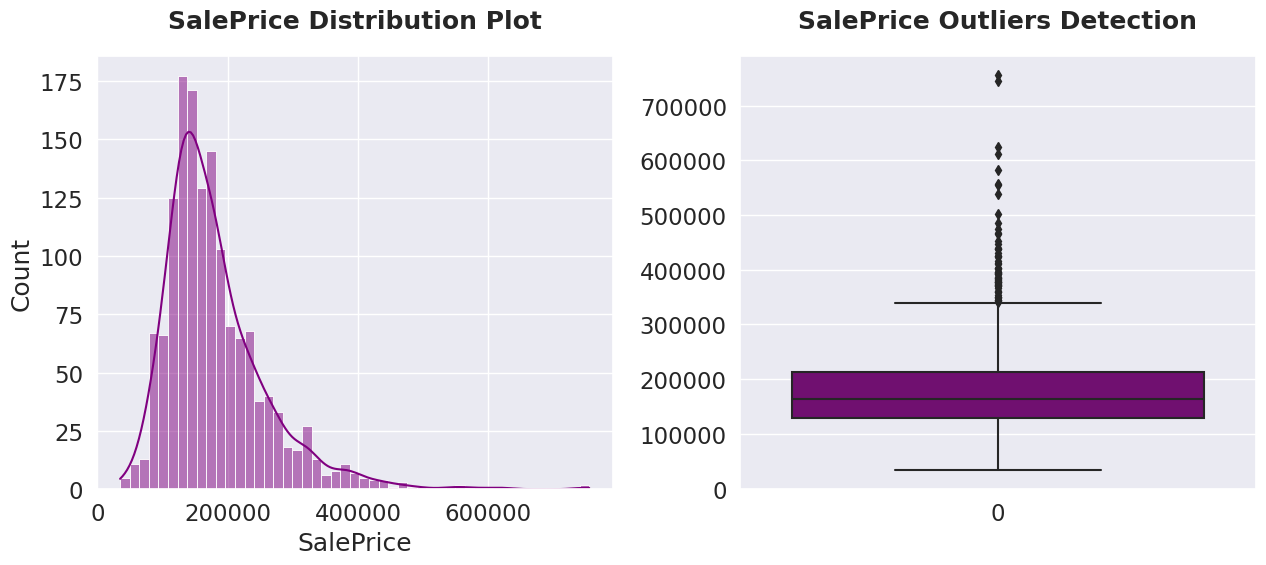

In [846]:
plt.figure(figsize=(13,6))

plt.subplot(1,2,1)
sns.histplot(df_train["SalePrice"],color="purple",kde=True)
plt.title("SalePrice Distribution Plot",fontweight="black",pad=20,size=18)

plt.subplot(1,2,2)
sns.boxplot(df_train["SalePrice"],color="purple")
plt.title("SalePrice Outliers Detection",fontweight="black",pad=20,size=18)
plt.tight_layout()
plt.show()

#### Предобработка данных

In [847]:
null_df = round(df_train.isnull().sum()/len(df_train)*100,2).sort_values().to_frame().rename(columns=
                                                                                    {0:"Train % of Missing Values"})
null_df["Test % of Missing Values"] = round(df_test.isnull().sum()/len(df_train)*100,2)

null_df[(null_df["Train % of Missing Values"]>45) | (null_df["Test % of Missing Values"]>45)]

,Train % of Missing Values,Test % of Missing Values
FireplaceQu,47.26,50.00
MasVnrType,59.73,61.23
Fence,80.75,80.07
Alley,93.77,92.60
MiscFeature,96.30,96.44
PoolQC,99.52,99.73


In [848]:
# train_df.shape, test_df.shape
df_train.shape, df_test.shape

((1460, 80), (1459, 79))

In [849]:
cols = ["FireplaceQu","Fence","Alley","MiscFeature","PoolQC"]

df_train.drop(columns=cols, inplace=True)
df_test.drop(columns=cols, inplace=True)

In [850]:
df_train.shape, df_test.shape

((1460, 75), (1459, 74))

Объединяем трейн и тест в единый датафрейм

In [851]:

target = df_train[["SalePrice"]].reset_index(drop=True)

df_train.drop(columns=["SalePrice"],inplace=True)

df = pd.concat([df_train,df_test]).reset_index(drop=True)

In [852]:
null_df = df.isnull().sum()[df.isnull().sum()>0].sort_values().to_frame().rename(columns={0:"Total Missing values"})
null_df["% of Missing Values"] = round(null_df["Total Missing values"]/len(df)*100,2)
null_df["Feature Data Type"] = df[null_df.index.tolist()].dtypes
null_df

,Total Missing values,% of Missing Values,Feature Data Type
BsmtUnfSF,1,0.03,float64
GarageArea,1,0.03,float64
GarageCars,1,0.03,float64
KitchenQual,1,0.03,object
Electrical,1,0.03,object
TotalBsmtSF,1,0.03,float64
BsmtFinSF2,1,0.03,float64
BsmtFinSF1,1,0.03,float64
SaleType,1,0.03,object
Exterior1st,1,0.03,object


In [853]:
for col in ['GarageYrBlt', 'GarageArea', 'GarageCars']:
    df[col] = df[col].fillna(0)

for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    df[col] = df[col].fillna('None')

for col in ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']:
    df[col] = df[col].fillna('None')

df['MSZoning'] = df.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

cat_cols = ['Utilities','Exterior1st','Exterior2nd','MasVnrType','Electrical',
            'KitchenQual','Functional','SaleType']

imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = imputer.fit_transform(df[cat_cols])

df["LotFrontage"] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
df["MasVnrArea"]  = df.groupby("MasVnrType")["MasVnrArea"].transform(lambda x: x.fillna(x.median()))
df["BsmtFinSF1"]  = df.groupby("BsmtFinType1")["BsmtFinSF1"].transform(lambda x: x.fillna(x.median()))
df["BsmtFinSF2"]  = df.groupby("BsmtFinType2")["BsmtFinSF2"].transform(lambda x: x.fillna(x.median()))

df["BsmtFullBath"] = df["BsmtFullBath"].fillna(0.0)
df["BsmtHalfBath"] = df["BsmtHalfBath"].fillna(0.0)
df["TotalBsmtSF"]  = df["BsmtFinSF1"] + df["BsmtFinSF2"]
df["BsmtUnfSF"]    = df["BsmtUnfSF"].fillna(df["BsmtUnfSF"].median())

In [854]:
print("Total Missing Values Left is:",df.isnull().sum().sum())

Total Missing Values Left is: 0


Разделяем назад датафреймы на тест и трейн

In [855]:
train_df = pd.concat([df.iloc[:len(target["SalePrice"]),:],target],axis=1)
test_df = df.iloc[len(target["SalePrice"]):,:]

In [856]:
train_df.shape, test_df.shape

((1460, 75), (1459, 74))

Новые фичи

In [857]:
train_df['RenovationStatus'] = (train_df['YearBuilt'] != train_df['YearRemodAdd']).astype(int)
test_df['RenovationStatus']  = (test_df['YearBuilt'] != test_df['YearRemodAdd']).astype(int)

train_df['AgeAtSale'] = train_df['YrSold'] - train_df['YearBuilt']
test_df['AgeAtSale'] = test_df['YrSold'] - test_df['YearBuilt']

train_df.drop(columns=["YearBuilt","YrSold","YearRemodAdd"],inplace=True)
test_df.drop(columns=["YearBuilt","YrSold","YearRemodAdd"],inplace=True)

In [858]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 74), (1459, 73))

In [859]:
train_df["Total_Bathrooms"] = (train_df["FullBath"] + (0.5 * train_df["HalfBath"]) + 
                               train_df["BsmtFullBath"] + (0.5 * train_df["BsmtHalfBath"]))
test_df["Total_Bathrooms"] = (test_df["FullBath"] + (0.5 * test_df["HalfBath"]) + 
                               test_df["BsmtFullBath"] + (0.5 * test_df["BsmtHalfBath"]))

In [860]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 75), (1459, 74))

In [861]:
train_df['Total_Porch_SF'] = (train_df['OpenPorchSF'] + train_df['3SsnPorch'] +train_df['EnclosedPorch'] +
                              train_df['ScreenPorch'] + train_df['WoodDeckSF'])
test_df['Total_Porch_SF'] = (test_df['OpenPorchSF'] + test_df['3SsnPorch'] +test_df['EnclosedPorch'] +
                              test_df['ScreenPorch'] + test_df['WoodDeckSF'])

cols = ["3SsnPorch","EnclosedPorch","ScreenPorch"]

train_df.drop(columns=cols,inplace=True)
test_df.drop(columns=cols,inplace=True)

In [862]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 73), (1459, 72))

In [863]:
train_df['Total_sqr_footage']=(train_df['BsmtFinSF1']+train_df['BsmtFinSF2']+train_df['1stFlrSF']+train_df['2ndFlrSF'])
test_df['Total_sqr_footage'] =(test_df['BsmtFinSF1']+test_df['BsmtFinSF2']+test_df['1stFlrSF']+test_df['2ndFlrSF'])

cols = ["BsmtFinSF2","BsmtUnfSF"]
train_df.drop(columns=cols,inplace=True)
test_df.drop(columns=cols,inplace=True)

In [864]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 72), (1459, 71))

In [865]:
def condition(df):
    df["Condition2"] = df["Condition2"].replace({"Norm":""}) #Norm means normal which indicates there's no second condition
    combined_condition = []
    for val1,val2 in zip(df["Condition1"],df["Condition2"]):
        if val2 == "":
            combined_condition.append(val1)
        elif val1==val2:
            combined_condition.append(val1)
        else:
            combined_condition.append(val1+val2)
            
    df["Combined_Condition"] = combined_condition
    df["ProximityStatus"] = (df["Combined_Condition"] == "Norm").astype(int)

In [866]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 72), (1459, 71))

In [867]:
condition(train_df)
condition(test_df)

train_df.drop(columns=["Condition1","Condition2","Combined_Condition"],inplace=True)
test_df.drop(columns=["Condition1","Condition2","Combined_Condition"],inplace=True)

In [868]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 71), (1459, 70))

In [869]:
train_df["HeatingQuality"] = train_df["Heating"] + "-" + train_df["HeatingQC"]
test_df["HeatingQuality"] = test_df["Heating"] + "-" + test_df["HeatingQC"]

train_df.drop(columns=["Heating","HeatingQC"],inplace=True)
test_df.drop(columns=["Heating","HeatingQC"],inplace=True)

# train_df["HeatingQuality"].replace({"Wall-Po":"Wall-TA"},inplace=True)
test_df["HeatingQuality"].replace({"Wall-Po":"Wall-TA"},inplace=True)

In [870]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 70), (1459, 69))

In [871]:
def boolean_feature(df):
    df["Has2ndFloor"] = (df['2ndFlrSF'] != 0).astype(int)
    df["HasGarage"]  = (df["GarageArea"] !=0).astype(int)
    df["HasBsmt"]    = (df["TotalBsmtSF"]!=0).astype(int)
    df["HasFirePlace"] = (df["Fireplaces"]!=0).astype(int)

boolean_feature(train_df)
boolean_feature(test_df)

In [872]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 74), (1459, 73))

Логарифмируем таргет

In [873]:
z = train_df["SalePrice"]
train_df["SalePrice"] = np.log1p(train_df["SalePrice"])

box-cox transformation

In [874]:
con_cols = ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","TotalBsmtSF","1stFlrSF","2ndFlrSF","LowQualFinSF",
            "GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF","PoolArea","MiscVal","AgeAtSale","Total_Porch_SF",
            "Total_sqr_footage"]
train_df[con_cols].skew().sort_values().to_frame().rename(columns={0:"Skewness"}).T

,GarageArea,AgeAtSale,2ndFlrSF,Total_Porch_SF,GrLivArea,1stFlrSF,TotalBsmtSF,WoodDeckSF,BsmtFinSF1,Total_sqr_footage,LotFrontage,OpenPorchSF,MasVnrArea,LowQualFinSF,LotArea,PoolArea,MiscVal
Skewness,0.179981,0.60903,0.81303,1.102313,1.36656,1.376757,1.405961,1.541376,1.685503,2.163968,2.213556,2.364342,2.677616,9.011341,12.207688,14.828374,24.476794


In [875]:
for feature in con_cols:
    train_df[feature] = boxcox1p(train_df[feature], boxcox_normmax(train_df[feature] + 1))
    test_df[feature] = boxcox1p(test_df[feature] + 1, boxcox_normmax(train_df[feature] + 1))

train_df[con_cols].skew().sort_values().to_frame().rename(columns={0:"Skewness"})

,Skewness
LotArea,-0.185485
Total_sqr_footage,-0.014054
LotFrontage,-0.011669
1stFlrSF,-0.006606
GrLivArea,0.005873
AgeAtSale,0.014514
Total_Porch_SF,0.181899
GarageArea,0.197874
BsmtFinSF1,0.382244
TotalBsmtSF,0.405566


In [876]:
cols = ["MiscVal","LowQualFinSF","PoolArea"]

train_df.drop(columns=cols, inplace=True)
test_df.drop(columns=cols, inplace=True)

In [877]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 71), (1459, 70))

Encoding

In [878]:
cols = ["Neighborhood","Exterior1st","Exterior2nd","HeatingQuality"]
for column in cols:
    data = train_df.groupby(column)["SalePrice"].mean()
    for value in data.index:
        train_df[column] = train_df[column].replace({value:data[value]})
        test_df[column] = test_df[column].replace({value:data[value]})

In [879]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 71), (1459, 70))

Label encoding

In [880]:
cols = ["HouseStyle","ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","Electrical","KitchenQual",
        "GarageQual","GarageCond"]
encoder = LabelEncoder()

train_df[cols] = train_df[cols].apply(encoder.fit_transform)
test_df[cols] = test_df[cols].apply(encoder.fit_transform)

In [881]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 71), (1459, 70))

In [882]:
train_df.isna().sum().sum()

0

One-hot encoding

In [883]:
df.isna().sum().sum()

0

In [884]:
cols = test_df.select_dtypes(include="object").columns

train_df = pd.get_dummies(train_df, columns=cols)
test_df = pd.get_dummies(test_df,columns=cols)

# train_df = pd.concat([df.iloc[:len(target["SalePrice"]),:],target],axis=1)
# test_df = df.iloc[len(target["SalePrice"]):,:]
# train_df.shape, test_df.shape

In [886]:
train_df.shape, test_df.shape
# df_train.shape, df_test.shape

((1460, 155), (1459, 149))

In [887]:
y = train_df["SalePrice"]

different_columns = set(train_df.columns) ^ set(test_df.columns)
# Drop the different columns from both DataFrames
train_df.drop(columns=different_columns, inplace=True)

train_df.shape, test_df.shape

((1460, 149), (1459, 149))

In [888]:
X = train_df

In [889]:
X.shape, test_df.shape

((1460, 149), (1459, 149))

Scaling

In [891]:
X = X.select_dtypes(include = ['float64', 'int64', 'bool'])
test_df = test_df.select_dtypes(include = ['float64', 'int64', 'bool'])

In [586]:
# # Assuming your DataFrame 'X' contains both numerical and categorical features
# numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
# categorical_features = X.select_dtypes(include=['object']).columns

# # Apply one-hot encoding to the categorical features
# preprocessor = ColumnTransformer(
#     transformers=[('num', RobustScaler(), numeric_features),
#                   ('cat', OneHotEncoder(), categorical_features)])

# X_scaled = preprocessor.fit_transform(X)

In [892]:
scaler =RobustScaler()
X_scaled = scaler.fit_transform(X)
test_df = scaler.fit_transform(test_df)

In [893]:
X_scaled.shape, test_df.shape, y.shape

((1460, 149), (1459, 149), (1460,))

### Модель

#### Отбор фичей

In [895]:
X_train = X
y_train = y
X_test = df_test

In [896]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor

X_train['random'] = np.random.uniform(0,100, size=X_train.shape[0])

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

x_tr, x_te, y_tr, y_te = train_test_split(X_train, y_train, test_size=0.2)
r = permutation_importance(rf, x_te, y_te, n_repeats=30, random_state=0)

permutation_importances = pd.Series(dict(zip(X_train.columns, r['importances_mean']))).sort_values(key=lambda x: abs(x), ascending=False)

# Separate columns with higher and lower importances than the 'random' column
higher_importance_columns = permutation_importances[permutation_importances > permutation_importances['random']].index.tolist()
lower_importance_columns = permutation_importances[permutation_importances <= permutation_importances['random']].index.tolist()

# Print or use the lists as needed
print("Columns with higher importance than 'random':", higher_importance_columns)
print("Columns with lower importance than 'random':", lower_importance_columns)

Columns with higher importance than 'random': ['OverallQual', 'Total_sqr_footage', 'Neighborhood', 'GrLivArea', 'GarageArea', '1stFlrSF', 'GarageCars', 'OverallCond', 'LotArea', 'AgeAtSale', 'CentralAir_N', 'LotFrontage', 'Total_Porch_SF', 'TotalBsmtSF', 'CentralAir_Y', 'Total_Bathrooms', 'MSZoning_C (all)', 'MoSold', 'GarageYrBlt']
Columns with lower importance than 'random': ['random', 'BsmtFinSF1', 'ExterCond', '2ndFlrSF', 'GarageType_Detchd', 'HasFirePlace', 'OpenPorchSF', 'TotRmsAbvGrd', 'Fireplaces', 'WoodDeckSF', 'MasVnrArea', 'KitchenQual', 'BsmtQual', 'Exterior1st', 'HeatingQuality', 'ExterQual', 'GarageFinish_Unf', 'BedroomAbvGr', 'LotConfig_Inside', 'MSSubClass', 'Exterior2nd', 'FullBath', 'BsmtExposure', 'BsmtFinType2_BLQ', 'PavedDrive_N', 'Functional_Typ', 'SaleCondition_Abnorml', 'Electrical', 'RenovationStatus', 'LandContour_Bnk', 'BsmtCond', 'HouseStyle', 'GarageCond', 'SaleCondition_Normal', 'MSZoning_RL', 'LandContour_HLS', 'ProximityStatus', 'LotShape_Reg', 'HalfBath

убираем фичи, не показавшие высокую значимость

In [ ]:
# X_train = X_train.loc[:, higher_importance_columns]
# X_test = X_test.loc[:, higher_importance_columns]
# X_train.shape, X_test.shape